# Diabetes
by Kenan Sooklall

Diabetes is a chronic (long-lasting) health condition that affects how your body turns food into energy.

Most of the food you eat is broken down into sugar (also called glucose) and released into your bloodstream. When your blood sugar goes up, it signals your pancreas to release insulin. Insulin acts like a key to let the blood sugar into your body’s cells for use as energy.

Source: [Centers for Disease Control and Preventation](https://www.cdc.gov/diabetes/basics/diabetes.html)

In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import shap
from sklearn import tree
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, normalize, LabelEncoder, MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
%matplotlib inline

Dropping
- A lot of missing values
    - weight 
    - payer code
    - medical_specialty
- Only one value
    - examide, citoglipton have 
- Conflict
    - race
- Duplicated patient_nbr

In [2]:
drop_cols = ['examide', 'citoglipton', 'encounter_id','weight', 'payer_code', 'medical_specialty', 'race', 'glimepiride-pioglitazone']
df = pd.read_csv('dataset_diabetes/diabetic_data.csv').drop(drop_cols, axis=1)
df['readmitted'] = df['readmitted'].map({'NO': 0, '>30': 1, '<30': 1})

Downsample

In [3]:
readmitted = df[df['readmitted'].eq(1)].drop_duplicates(['patient_nbr'])
not_readmitted = df[df['readmitted'].eq(0)].drop_duplicates(['patient_nbr']).groupby('readmitted').sample(28784)

df = pd.concat([readmitted, not_readmitted]).reset_index(drop=True).\
            replace('?', np.nan).\
            drop(['patient_nbr'], axis=1)

In [4]:
young = 'young'
middle = 'adult'
old = 'old'

age_mapping = {'[0-10)': young, '[10-20)': young, '[20-30)': young, '[30-40)': middle, '[40-50)': middle, '[50-60)': middle,
         '[60-70)': old, '[70-80)': old, '[80-90)': old, '[90-100)': old}
df['age_mapped'] = df['age'].map(age_mapping)

In [5]:
drug_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
             'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
             'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
             'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 
             'metformin-rosiglitazone', 'metformin-pioglitazone']
diag_cols = ['Circulatory', 'Diabetes', 'Digestive', 'Genitourinary', 'Injury', 
             'Muscoloskeletal', 'Neoplasms', 'Other', 'Respiratory']

In [6]:
print(df.shape)
df.head()

(57568, 42)


,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,age_mapped
0,Female,[10-20),1,1,7,3,59,0,18,0,...,No,Up,No,No,No,No,Ch,Yes,1,young
1,Male,[50-60),2,1,2,3,31,6,16,0,...,No,Steady,No,No,No,No,No,Yes,1,adult
2,Male,[70-80),1,1,7,5,73,0,12,0,...,No,No,No,No,No,No,No,Yes,1,old
3,Female,[40-50),1,1,7,9,47,2,17,0,...,No,Steady,No,No,No,No,No,Yes,1,adult
4,Male,[60-70),2,1,4,7,62,0,11,0,...,No,Steady,No,No,No,No,Ch,Yes,1,old


difference between high blood sugar >200 and very high blood sugar >300
   - how certain medication doses goes up

In [7]:
def glu_plots(df, target):
    fig, axs = plt.subplots(5, 4, figsize = (15, 10))
    for idx, i in enumerate(axs.flatten()):
        drug = drug_cols[idx]
        sns.countplot(data=df[drug_cols + [target]], x=drug, hue=target, ax=i)#.set(title=drug)
        i.set_yticks([0, 500,1000,1500])
        
        if idx != 3:
            i.legend([],[], frameon=False)
        else:
            i.legend(title=target, loc='upper right')
    
    plt.tight_layout()

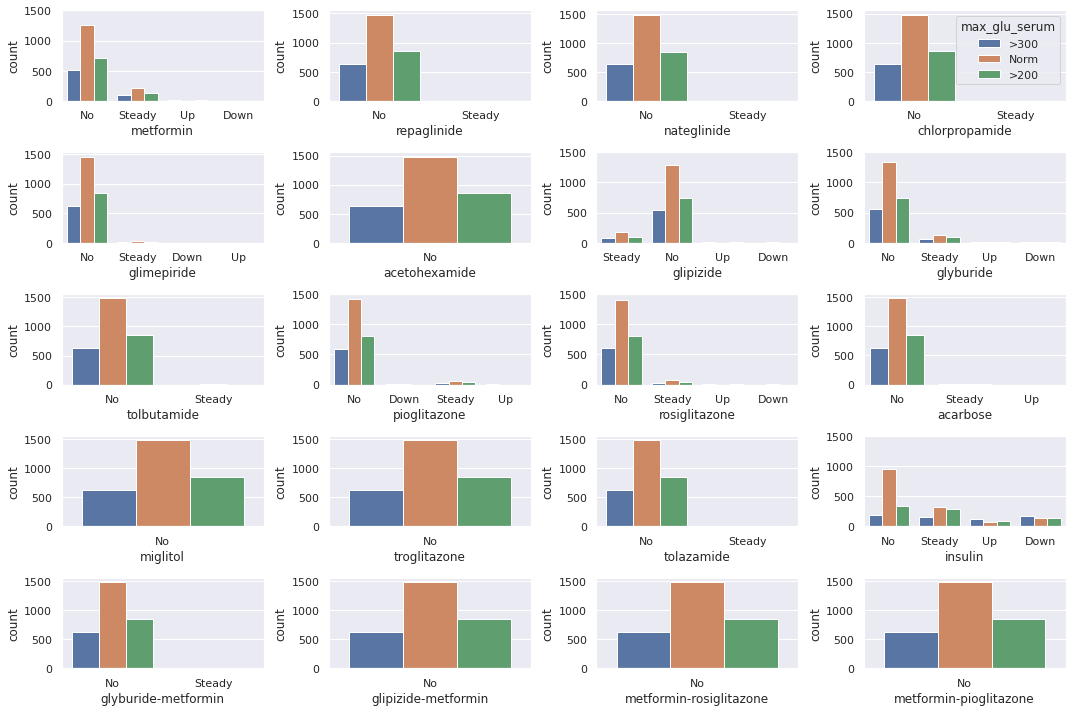

In [8]:
glu_plots(df[df['max_glu_serum'].ne('None')].reset_index(drop=True), target='max_glu_serum')

   - number of changes

In [9]:
df.columns

Index(['gender', 'age', 'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'metformin-rosiglitazone', 'metformin-pioglitazone', 'change',
       'diabetesMed', 'readmitted', 'age_mapped'],
      dtype='object')

The data set contains 22 columns and 253680 rows
- Encounter ID: Unique identifier of an encounter
- Patient number: Unique identifier of a patient
- Race Values: Caucasian, Asian, African American, Hispanic, and other
- Gender Values: male, female, and unknown/invalid
- Age: Grouped in 10-year intervals - 0, 10), 10, 20), …, 90, 100)
- Weight: Weight in pounds
- Admission type: Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn, and not available
- Discharge disposition: Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not available
- Admission source: Integer identifier corresponding to 21 distinct values, for example, physician referral, emergency room, and transfer from a hospital
- Time in hospital: Integer number of days between admission and discharge
- Payer code: Integer identifier corresponding to 23 distinct values, for example, Blue Cross/Blue Shield, Medicare, and self-pay Medical
- Medical specialty: Integer identifier of a specialty of the admitting physician, corresponding to 84 distinct values, for example, cardiology, internal medicine, family/general practice, and surgeon
- Number of lab: procedures Number of lab tests performed during the encounter
- Number of procedures: Numeric Number of procedures (other than lab tests) performed during the encounter
- Number of medications: Number of distinct generic names administered during the encounter
- Number of outpatient: visits Number of outpatient visits of the patient in the year preceding the encounter
- Number of emergency: visits Number of emergency visits of the patient in the year preceding the encounter
- Number of inpatient: visits Number of inpatient visits of the patient in the year preceding the encounter
- Diagnosis 1: The primary diagnosis (coded as first three digits of ICD9); 848 distinct values
- Diagnosis 2: Secondary diagnosis (coded as first three digits of ICD9); 923 distinct values
- Diagnosis 3: Additional secondary diagnosis (coded as first three digits of ICD9); 954 distinct values
- Number of diagnoses: Number of diagnoses entered to the system 0%
- Glucose serum test: result Indicates the range of the result or if the test was not taken. Values: “>200,” “>300,” “normal,” and “none” if not measured
- A1c test result: Indicates the range of the result or if the test was not taken. Values - '>8' if the result was greater than 8%, “>7” if the result was greater than 7% but less than 8%, “normal” if the result was less than 7%, and “none” if not measured. 7% to 8% is an increase of ~30mg/dl of glucose, 6%=120mg/dl
- Change of medications: Indicates if there was a change in diabetic medications (either dosage or generic name). Values - 'change' and 'no change'
- Diabetes medications: Indicates if there was any diabetic medication prescribed. Values: 'yes' and 'no'
- 24 features for medications: glyburide-metformin, glipizide-metformin, glimepiride-pioglitazone, metformin-rosiglitazone, and metformin-pioglitazone, the feature indicates whether the drug was prescribed or there was a change in the dosage. Values - 'up' if the dosage was increased during the encounter, 'down' if the dosage was decreased, 'steady' if the dosage did not change, and 'no' if the drug was not prescribed
- Readmitted Days: Values '<30' if the patient was readmitted in less than 30 days, '>30' if the patient was readmitted in more than 30 days, and 'No' for no record of readmission

source: https://archive-beta.ics.uci.edu/ml/datasets/diabetes+130+us+hospitals+for+years+1999+2008

admission_type_id Description (ordered)
- 1. Emergency
- Urgent
- Elective
- Newborn
- Not Available
- NULL
- Trauma Center
- 8. Not Mapped

discharge_disposition_id Description (ordered)
- 1. Discharged to home
- Discharged/transferred to another short term hospital
- Discharged/transferred to SNF
- Discharged/transferred to ICF
- Discharged/transferred to another type of inpatient care institution
- Discharged/transferred to home with home health service
- Left AMA
- Discharged/transferred to home under care of Home IV provider
- Admitted as an inpatient to this hospital
- Neonate discharged to another hospital for neonatal aftercare
- Expired
- Still patient or expected to return for outpatient services
- Hospice / home
- Hospice / medical facility
- Discharged/transferred within this institution to Medicare approved swing bed
- Discharged/transferred/referred another institution for outpatient services
- Discharged/transferred/referred to this institution for outpatient services
- NULL
- Expired at home. Medicaid only, hospice.
- Expired in a medical facility. Medicaid only, hospice.
- Expired, place unknown. Medicaid only, hospice.
- Discharged/transferred to another rehab fac including rehab units of a hospital .
- Discharged/transferred to a long term care hospital.
- Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.
- Not Mapped
- Unknown/Invalid
- Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere
- Discharged/transferred to a federal health care facility.
- Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital
- 30. Discharged/transferred to a Critical Access Hospital (CAH).

###  Exploratory Data Analysis

Very lucky to find a dataset with no missing values and no duplicated rows

we can see the data are all on very different scales, which is to be expected. An initial point of concern is  SkinThichkness of 0mm, however that could be more of a percision issue. Another column of concern is BMI, BloodPressure and Glucose, it can't be 0. The min age being greater than 0 is expected and all other values look normal

In [10]:
metrics = ['mean', 'median', 'std']
df.groupby(['readmitted']).agg({"number_diagnoses": metrics,
                            "num_medications": metrics,
                               'num_procedures': metrics,
                               'time_in_hospital': metrics
                               })

number_diagnoses                  num_medications                   \
                       mean median       std            mean median       std   
readmitted                                                                      
0                  7.220018      8  2.018567       15.627467     14  8.469061   
1                  7.500035      8  1.864984       16.064619     15  7.903343   

           num_procedures                  time_in_hospital                   
                     mean median       std             mean median       std  
readmitted                                                                    
0                1.414293      1  1.744717         4.255767      3  2.968778  
1                1.371074      1  1.739302         4.500869      4  2.993095

<AxesSubplot:xlabel='readmitted', ylabel='count'>

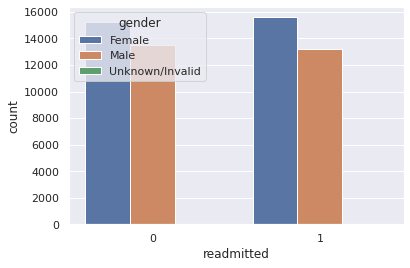

In [11]:
sns.countplot(x='readmitted', data=df, hue='gender')

gender seems to be mostly independant if someone will be remitted

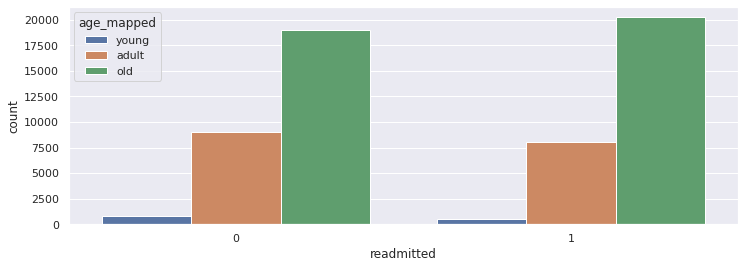

In [17]:
plt.figure(figsize=(12, 4))
sns.countplot(x='readmitted', data=df, hue='age_mapped')
plt.savefig('graphs/age.jpg', dpi=200)

The older portion of the population is the majority for all ranges of readmitted

## Feature extractor

Quantify categorical data

quantify variables
- age - take the median values
- readmitted - 0: NO 1: other

In [18]:
df = df.replace(['No','NO', 'None', 'Steady', 'Up', 'Down', 'Yes', 'Ch', 'Norm'], [0,0,0,1,1,1,1,1,1])
df['age'] = df['age'].map(lambda x: sum([int(i) for i in x[1:-1].split('-')]) // 2)
df['max_glu_serum_num'] = df['max_glu_serum'].map({0: 0, 1: 1, '>200': 1, '>300': 1}).astype(int)
df['A1Cresult_num'] = df['A1Cresult'].map({0: 0, 1: 1, '>8': 1, '>7': 1}).astype(int)
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})
df = df.dropna(subset=['gender'])

Map ids

In [19]:
def map_diagnosis(df, cols):    
    for i in cols:
        df[i] = pd.to_numeric(df[i], errors='coerce')
    
    for col in cols:
        df["diag"] = 'Other'
        df.loc[df[col].between(459, 785) | df[col].eq(785), "diag"] = "Circulatory"
        df.loc[df[col].between(460, 519) | df[col].eq(786), "diag"] = "Respiratory"
        df.loc[df[col].between(520, 579) | df[col].eq(787), "diag"] = "Digestive"
        df.loc[df[col].between(250, 251), "diag"] = "Diabetes"
        df.loc[df[col].between(800, 999), "diag"] = "Injury"
        df.loc[df[col].between(710, 739), "diag"] = "Muscoloskeletal"
        df.loc[df[col].between(580, 629) | df[col].eq(788), "diag"] = "Genitourinary"
        neoplasms_codes = df[col].between(140, 249) | df[col].between(251, 279) | df[col].isin([780,781,784]) | df[col].between(790, 799)
        df.loc[neoplasms_codes, "diag"] = "Neoplasms"
        df[col] = df["diag"]
        df = df.drop("diag", axis=1)

    return df

In [20]:
def map_id_cols(df):
    admission_type_maps = {
        1: 'emergency', 2: 'urgent', 3: 'elective', 4: 'other', 
        5: 'not Available', 6: np.nan, 7: 'trauma center', 8: np.nan}
    
    discharge_disposition_map = {
        1:"home", 2:"other", 3:"other", 4:"other",
        5:"other",6:"home",7:"other",8:"home",9:"other",
        10:"other",11:"other",12:"other", 13:"home",14:"other",15:"other",
        16:"other",17:"other",18:np.nan,19:"home",20:"other",21:"other",
        22:"other",23:"other",24:"other",25:np.nan,26:np.nan,27:"other",28:"other",29:"other",30:"other"}
    
    admission_source_map = {
        1:"referral", 2:"referral", 3:"referral", 4:"other", 5:"other", 6:"other", 7:"emergency",
        8:"other", 9:"other", 10:"other", 11:"other", 13:"other", 14:"other", 15:np.nan, 17:np.nan,
        20:np.nan, 21:np.nan, 22:"other", 25:"other"}
    
    df['admission_type_id_lbl'] = df['admission_type_id'].map(admission_type_maps)
    df['discharge_disposition_id_lbl'] = df['discharge_disposition_id'].map(discharge_disposition_map)
    df['admission_source_id_lbl'] = df['admission_source_id'].map(admission_source_map)
    
    return df

In [21]:
df = map_diagnosis(df, ["diag_1","diag_2","diag_3"])
df = map_id_cols(df)

In [22]:
lbl = LabelEncoder()
for i in ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']:
    df[i] = lbl.fit_transform(df[i + '_lbl'])

Get dummies for diag columns

In [23]:
diag = pd.get_dummies(df['diag_1']) + pd.get_dummies(df['diag_2']) + pd.get_dummies(df['diag_3'])
df = pd.concat([df.drop(df.filter(like='diag_').columns, axis=1), diag], axis=1)
df = pd.concat([df, pd.get_dummies(df['age_mapped'])], axis=1)

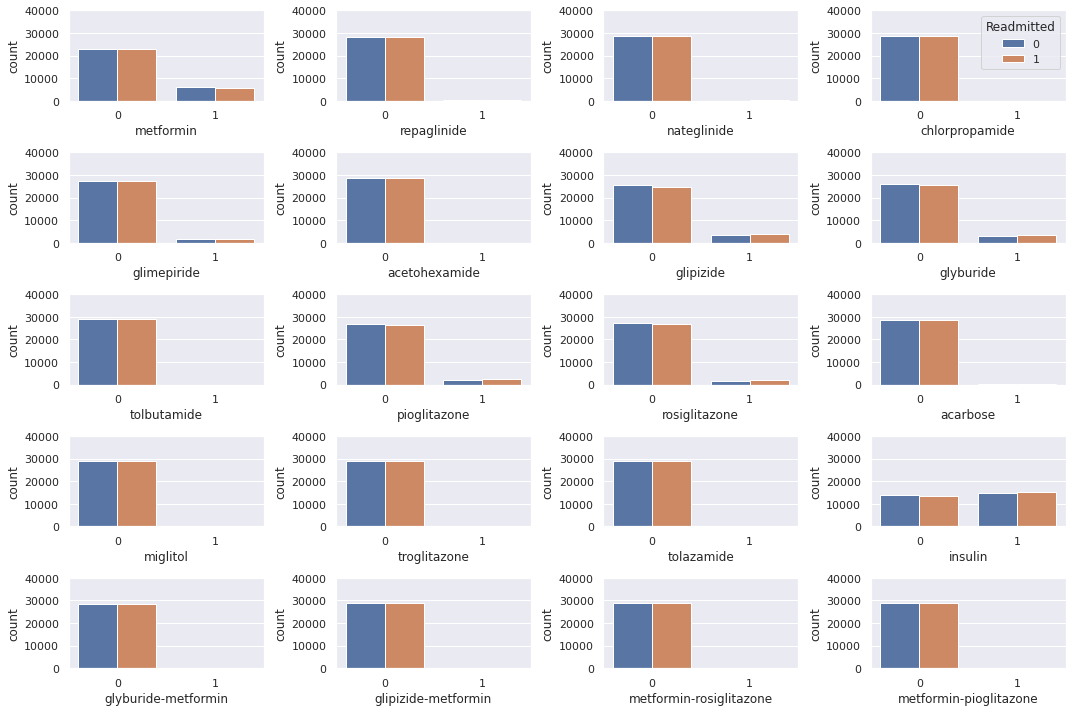

In [25]:
fig, axs = plt.subplots(5, 4, figsize = (15, 10))
for idx, i in enumerate(axs.flatten()):
    drug = drug_cols[idx]
    sns.countplot(data=df[drug_cols + ['readmitted']], x=drug, hue='readmitted', ax=i)#.set(title=drug)
    i.set_yticks([0, 1e4,2e4,3e4,4e4])

    if idx != 3:
        i.legend([],[], frameon=False)
    else:
        i.legend(title="Readmitted", loc='upper right')

plt.tight_layout()
plt.savefig('graphs/drug.jpg', dpi=200)

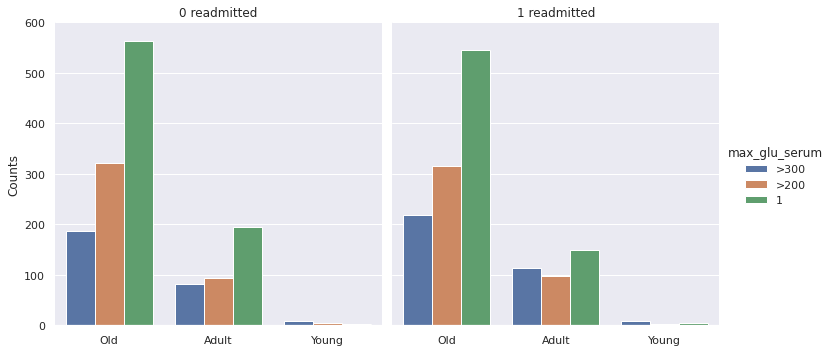

In [26]:
glu = df[['max_glu_serum', 'age_mapped', 'readmitted']].query('max_glu_serum != 0').groupby('readmitted').sample(1456)
g = sns.catplot(x='age_mapped', hue='max_glu_serum', col='readmitted', data=glu, kind='count', hue_order=['>300', '>200', 1])

g.set_axis_labels("", "Counts")\
  .set_xticklabels(["Old", "Adult", "Young"])\
  .set_titles("{col_name} {col_var}")\
  .set(ylim=(0, 600))\
  .despine(left=True)

plt.savefig('graphs/max_glu_serum.jpg', dpi=200)

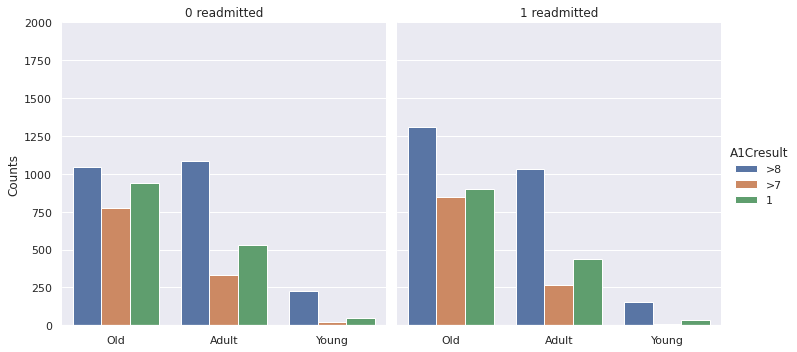

In [34]:
a1c = df[['A1Cresult', 'age_mapped', 'readmitted']].query('A1Cresult != 0').groupby('readmitted').sample(4999)
g = sns.catplot(x='age_mapped', hue='A1Cresult', col='readmitted', data=a1c, kind='count', hue_order=['>8', '>7', 1])

g.set_axis_labels("", "Counts")\
  .set_xticklabels(["Old", "Adult", "Young"])\
  .set_titles("{col_name} {col_var}")\
  .set(ylim=(0, 2000))\
  .despine(left=True)

plt.savefig('graphs/A1Cresults.jpg', dpi=200)

Closer look at A1C results and Glucose serum test

time in hospital
 - staying longer lead to high readmittion

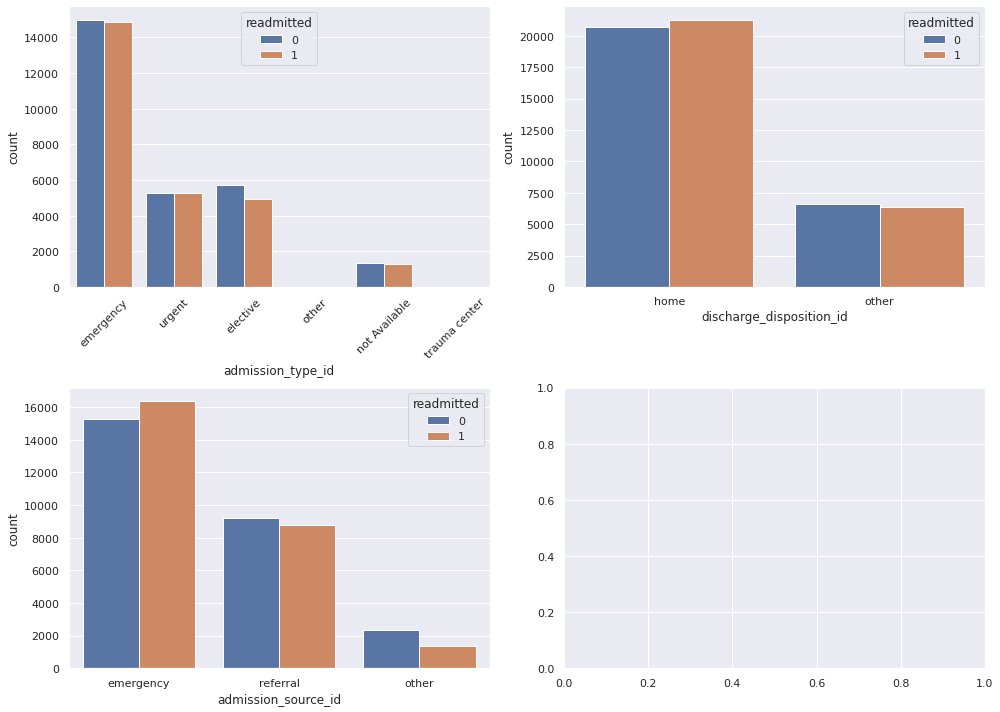

In [32]:
cat_cols = ['admission_type_id_lbl', 'discharge_disposition_id_lbl', 'admission_source_id_lbl']
fig, axes = plt.subplots(2,2, figsize=(14,10))
for idx, ax in enumerate(axes.flatten()):
    if idx > 2:
        continue
    g = sns.countplot(x=cat_cols[idx], data=df, hue='readmitted', ax=ax)
    if idx == 0:
        g.set_xticklabels(g.get_xticklabels(), rotation=45)
    g.set_xlabel(cat_cols[idx][:-4])
        
    #extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    #plt.savefig(f'graphs/{nums[idx]}.jpg', bbox_inches=extent.expanded(1.35, 1.35))
    #plt.savefig(f'graphs/{cat_cols[idx][:-4]}.jpg', bbox_inches=extent.expanded(1.35, 1.35))

plt.tight_layout()
plt.savefig(f'graphs/type_dis_source.jpg', dpi=200)


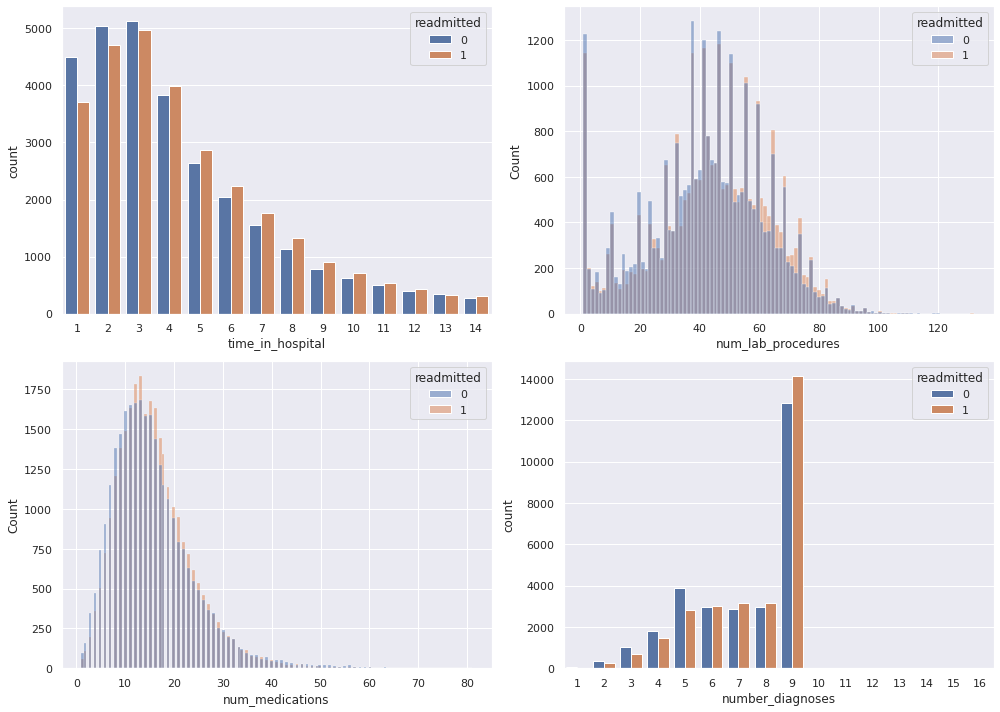

In [33]:
nums =['time_in_hospital', 'num_lab_procedures', 'num_medications','number_diagnoses']
fig, axes = plt.subplots(2,2, figsize=(14,10))
for idx, ax in enumerate(axes.flatten()):
    if idx in [1, 2]:
        sns.histplot(x=nums[idx], data=df, hue='readmitted', ax=ax)
    else:
        sns.countplot(x=nums[idx], data=df, hue='readmitted', ax=ax)
    
    #extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.tight_layout()
plt.savefig(f'graphs/hosp_lab_med_diag.jpg', dpi=200)#bbox_inches=extent.expanded(1.35, 1.35))

In [ ]:
plt.figure(figsize=(14, 6))
df['jitter_time_in_hospital'] = df['time_in_hospital'] + np.random.rand(df.shape[0])
sns.scatterplot(x='jitter_time_in_hospital', y='num_medications', hue='readmitted', data=df)

Dropped for mostly 0s
 - number_inpatient
 - number_emergency
 - number_outpatient
 - max_glu_serum
 - A1Cresult

# Modeling

In [16]:
features = ['gender', 'old', 'young', 'adult', 'time_in_hospital', 'num_lab_procedures', 
            'num_procedures', 'num_medications', 'number_diagnoses', 'diabetesMed', 'change']
glucose_tests = ['max_glu_serum_num', 'A1Cresult_num']
id_cols = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
num_cols = ['time_in_hospital','num_lab_procedures', 'num_medications','number_diagnoses']
model_features = features + glucose_tests + drug_cols + id_cols

In [17]:
seed = 42
diab_df = df[model_features + ['readmitted']]

In [18]:
scaler = StandardScaler()
diab_df.loc[:, num_cols + id_cols] = scaler.fit_transform(diab_df[num_cols + id_cols])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
X_train, X_test, y_train, y_test = train_test_split(diab_df.drop(['readmitted'], axis=1), diab_df['readmitted'], test_size=0.15)
print('X_train: {} X_test: {}'.format(X_train.shape[0], X_test.shape[0]))
diab_df.head()

X_train: 48931 X_test: 8636


,gender,old,young,adult,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,diabetesMed,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,metformin-rosiglitazone,metformin-pioglitazone,admission_type_id,discharge_disposition_id,admission_source_id,readmitted
0,1.0,0,1,0,-0.460633,0.791352,0,0.260625,0.843333,1,...,0,1,0,0,0,0,-0.460341,-0.57119,-0.847375,1
1,0.0,0,0,1,-0.460633,-0.618496,6,0.015738,0.843333,1,...,0,1,0,0,0,0,1.552989,-0.57119,1.020907,1
2,0.0,1,0,0,0.209731,1.496277,0,-0.474038,0.328779,1,...,0,0,0,0,0,0,-0.460341,-0.57119,-0.847375,1
3,1.0,0,0,1,1.550459,0.187132,2,0.138181,0.843333,1,...,0,1,0,0,0,0,-0.460341,-0.57119,-0.847375,1
4,0.0,1,0,0,0.880095,0.942408,0,-0.596482,-0.185775,1,...,0,1,0,0,0,0,1.552989,-0.57119,0.086766,1


## Model 1

In [20]:
model_parameters = {
    'svm': {
        'model': SVC(gamma='auto'),
        'params': {
            'C': [1,10,20],
            'kernel': ['rbf', 'linear']
        }
    },
    'logistic_regression': {
        'model': LogisticRegression(),
        'params': {
            'penalty': ['l1', 'l2', 'elasticnet', 'none'],
            'C': [1, 10, 100, 1000],
            'solver': ['lbfgs', 'newton-cg', 'liblinear'],
            'max_iter': [100,1000]
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [int(i) for i in range(50, 200, 25)],
            'max_features': ['auto', 'sqrt', None],
            'max_depth': [2, 4],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'bootstrap': [True, False],
            'oob_score': [True, False]
        }        
    }
}

In [27]:
scores = []

for model, params in model_parameters.items():
    print(f'Training: {model}')
    clf = GridSearchCV(params['model'], params['params'], cv=2, return_train_score=False, verbose=1, n_jobs=-1)
    clf.fit(X_train, y_train)
    scores.append({
        'model': model,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

Training: svm
Fitting 2 folds for each of 6 candidates, totalling 12 fits
Training: logistic_regression
Fitting 2 folds for each of 96 candidates, totalling 192 fits


/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_sele

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_

One or more of the test scores are non-finite: [       nan        nan 0.54930411 0.54854794 0.54889537 0.54881362
        nan        nan        nan 0.54893624 0.54860925        nan
        nan        nan 0.54932454 0.54889537 0.54889537 0.54881362
        nan        nan        nan 0.54862969 0.54860925        nan
        nan        nan 0.54858881 0.54877274 0.54858881 0.54862969
        nan        nan        nan 0.54893624 0.54860925        nan
        nan        nan 0.54858881 0.54865012 0.54858881 0.54862969
        nan        nan        nan 0.54862969 0.54860925        nan
        nan        nan 0.54860925 0.5482414  0.54860925 0.54860925
        nan        nan        nan 0.54893624 0.54860925        nan
        nan        nan 0.54858881 0.54877275 0.54860925 0.54860925
        nan        nan        nan 0.54862969 0.54860925        nan
        nan        nan 0.54858881 0.5485275  0.54860925 0.54862969
        nan        nan        nan 0.54893624 0.54860925        nan
        nan    

Training: random_forest
Fitting 2 folds for each of 576 candidates, totalling 1152 fits


/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 455, in _check_solver
    "penalty='none' is not supported for the liblinear solver"
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_sele

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_v

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_s

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_sele

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 455, in _check_solver
    "penalty='none' is not supported for the liblinear solver"
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_sele

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selectio

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/sit

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 455, in _check_solver
    "penalty='none' is not supported for the liblinear solver"
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_sele

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 455, in _check_solver
    "penalty='none' is not supported for the liblinear solver"
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_sele

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selectio

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_s

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_v

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_mod

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

One or more of the test scores are non-finite: [0.5506325  0.54934496 0.55159304 0.55275797 0.55202222 0.55236964
 0.55181786 0.55294189 0.55322802 0.55320756 0.55206309 0.55302363
 0.55239005 0.55149084 0.55224702 0.55161349 0.55163393 0.55292143
 0.55292147 0.55220614 0.55322799 0.55283968 0.55420897 0.55194049
 0.55218572 0.55265575 0.55034637 0.55181781 0.55351408 0.55177702
 0.55214483 0.55140913 0.55275795 0.55308494 0.552901   0.55226745
 0.55104123 0.55373893 0.5530236  0.55050994 0.55402505 0.55345279
 0.55333019 0.55279881 0.55263534 0.55247182 0.55275796 0.55110257
 0.55347328 0.55424985 0.55239011 0.55355501 0.55171567 0.55279884
 0.5541272  0.55153175 0.55243094 0.5530032  0.55206311 0.55294187
 0.55341193 0.55226746 0.55275792 0.55236965 0.55130697 0.55351411
 0.55296232 0.55228794 0.55271708 0.55214488 0.55187915 0.5527784
 0.55294187 0.55022378 0.55273753 0.5524514  0.55144999 0.55050989
 0.55145001 0.55310536 0.5521653  0.55167476 0.55245141 0.55161347
 0.55341195 0.55

In [28]:
model_df = pd.DataFrame(scores)
print(model_df)
best_model = model_df.loc[2].to_dict()
print(best_model)

                 model  best_score  \
0                  svm    0.570048   
1  logistic_regression    0.549325   
2        random_forest    0.560258   

                                         best_params  
0                         {'C': 10, 'kernel': 'rbf'}  
1  {'C': 1, 'max_iter': 1000, 'penalty': 'l1', 's...  
2  {'bootstrap': True, 'max_depth': 4, 'max_featu...  
{'model': 'random_forest', 'best_score': 0.5602583064718132, 'best_params': {'bootstrap': True, 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 125, 'oob_score': True}}


In [77]:
rf_model1 = RandomForestClassifier(**best_model['best_params']).fit(X_train,y_train)
rf_pred1 = rf_model1.predict(X_test)
y_prob1 = rf_model1.predict_proba(X_test)[:, 1]
cr = '\n'.join(classification_report(y_test, rf_pred1, target_names=['no', 'yes']).split('\n')[:4]).replace('\n\n', '\n')
print(cr)
print('Training : {}'.format(rf_model1.score(X_train, y_train)))
print('Testing: {}'.format(rf_model1.score(X_test,y_test)))
print('Roc AUC: {}'.format(roc_auc_score(y_test, y_prob1)))

              precision    recall  f1-score   support
          no       0.55      0.51      0.53      4321
         yes       0.55      0.58      0.56      4314
Training : 0.5555782632686844
Testing: 0.549160393746381
Roc AUC: 0.5684320367469325


In [32]:
pd.DataFrame(classification_report(y_test, rf_pred1, target_names=['no', 'yes'], output_dict=True)).iloc[:, :2].T.round(2).reset_index().rename(columns={'index': 'target'}).to_csv('m1_classification_report.csv', index=False)

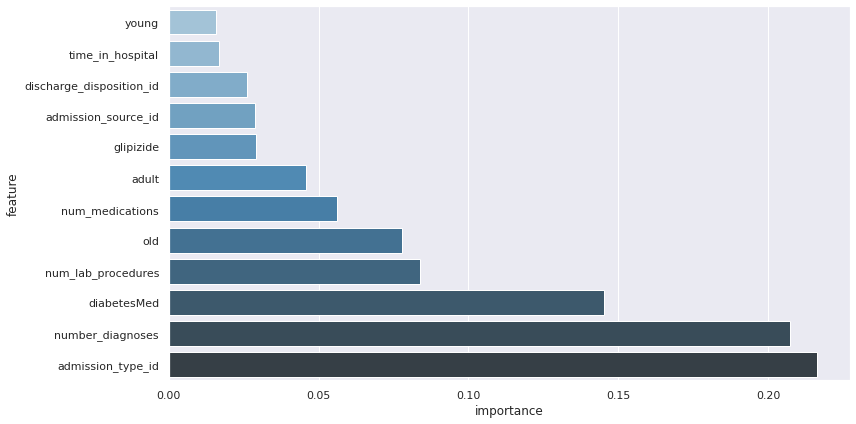

In [78]:
lst = []

for idx, v in enumerate(rf_model1.feature_importances_):
    lst.append({'feature': model_features[idx], 'importance': v})
df1 = pd.DataFrame(lst).sort_values('importance')

plt.figure(figsize=(12,6))
sns.barplot(data=df1.tail(12), x='importance', y='feature', palette='Blues_d', ci=1)
plt.tight_layout()
plt.savefig('graphs/m1_feature_importance.jpg')

In [ ]:
explainer = shap.TreeExplainer(rf_model)
choosen_instance = X_test.iloc[[43]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

## Modeling 2

dropping drug and id cols, focus on A1C

In [21]:
features = ['gender', 'insulin', 'young', 'old', 'adult']
a1c_features = ['a1c_norm', 'alc>7', 'alc>8']

model_features = features + a1c_features
df2 = df[df['A1Cresult'].ne(0)][features + ['A1Cresult', 'readmitted']]
a1c_dummies = pd.get_dummies(df2['A1Cresult']).rename(columns={1: 'a1c_norm', '>7': 'alc>7', '>8': 'alc>8'})
df2 = pd.concat([df2.drop(['A1Cresult'], axis=1), a1c_dummies], axis=1)[model_features + ['readmitted']]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df2.drop(['readmitted'], axis=1), df2['readmitted'], test_size=0.15)
print('X_train: {} X_test: {}'.format(X_train.shape[0], X_test.shape[0]))
df2.head()

X_train: 8492 X_test: 1499


,gender,insulin,young,old,adult,a1c_norm,alc>7,alc>8,readmitted
39,1.0,1,0,1,0,0,1,0,1
58,1.0,0,0,1,0,1,0,0,1
62,0.0,1,0,1,0,1,0,0,1
63,0.0,1,0,1,0,1,0,0,1
64,1.0,1,0,1,0,0,1,0,1


In [36]:
scores = []

for model, params in model_parameters.items():
    print(f'Training: {model}')
    clf = GridSearchCV(params['model'], params['params'], cv=5, return_train_score=False, verbose=1, n_jobs=-1)
    clf.fit(X_train, y_train)
    scores.append({
        'model': model,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

Training: svm
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Training: logistic_regression
Fitting 5 folds for each of 96 candidates, totalling 480 fits


/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet pena

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_v

One or more of the test scores are non-finite: [       nan        nan 0.54039813 0.53992974 0.53992974 0.53992974
        nan        nan        nan 0.53992974 0.53992974        nan
        nan        nan 0.54039813 0.53992974 0.53992974 0.53992974
        nan        nan        nan 0.53992974 0.53992974        nan
        nan        nan 0.53992974 0.53992974 0.53992974 0.53992974
        nan        nan        nan 0.53992974 0.53992974        nan
        nan        nan 0.53992974 0.53992974 0.53992974 0.53992974
        nan        nan        nan 0.53992974 0.53992974        nan
        nan        nan 0.53992974 0.53992974 0.53992974 0.53992974
        nan        nan        nan 0.53992974 0.53992974        nan
        nan        nan 0.53992974 0.53992974 0.53992974 0.53992974
        nan        nan        nan 0.53992974 0.53992974        nan
        nan        nan 0.53992974 0.53992974 0.53992974 0.53992974
        nan        nan        nan 0.53992974 0.53992974        nan
        nan    

Training: random_forest
Fitting 5 folds for each of 576 candidates, totalling 2880 fits


/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selectio

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_sele

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 451, in _check_solver
    " got solver={}.".format(solver))
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_valid

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_v

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selectio

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 455, in _check_solver
    "penalty='none' is not supported for the liblinear solver"
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_sele

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 451, in _check_solver
    " got solver={}.".format(solver))
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_valid

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 451, in _check_solver
    " got solver={}.".format(solver))
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_valid

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 451, in _check_solver
    " got solver={}.".format(solver))
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_valid

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 451, in _check_solver
    " got solver={}.".format(solver))
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_valid

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call las

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

One or more of the test scores are non-finite: [0.54601874 0.5412178  0.54250585 0.54461358 0.54250585 0.54543326
 0.54473068 0.54531616 0.53957845 0.54473068 0.54320843 0.54473068
 0.54496487 0.54496487 0.54484778 0.54192037 0.54613583 0.54028103
 0.54473068 0.54473068 0.54473068 0.54098361 0.54473068 0.54449649
 0.53875878 0.54461358 0.54473068 0.54496487 0.54449649 0.54192037
 0.54391101 0.54683841 0.5442623  0.54332553 0.53957845 0.54473068
 0.54590164 0.54074941 0.54531616 0.54215457 0.54437939 0.54473068
 0.54578454 0.54473068 0.54543326 0.54566745 0.54156909 0.5442623
 0.5471897  0.54168618 0.54508197 0.54227166 0.5441452  0.54192037
 0.54215457 0.54473068 0.54473068 0.54555035 0.54543326 0.54496487
 0.54238876 0.53782201 0.54250585 0.5471897  0.54473068 0.54672131
 0.54496487 0.54601874 0.54566745 0.54601874 0.53957845 0.54473068
 0.54519906 0.54367681 0.54519906 0.54297424 0.54192037 0.54192037
 0.54543326 0.54461358 0.54484778 0.54601874 0.54449649 0.54262295
 0.54203747 0.53

In [37]:
model_df = pd.DataFrame(scores)
print(model_df)
best_model = model_df.loc[2].to_dict()
print(best_model)

                 model  best_score  \
0                  svm    0.544848   
1  logistic_regression    0.540398   
2        random_forest    0.547190   

                                         best_params  
0                          {'C': 1, 'kernel': 'rbf'}  
1  {'C': 1, 'max_iter': 100, 'penalty': 'l1', 'so...  
2  {'bootstrap': True, 'max_depth': 2, 'max_featu...  
{'model': 'random_forest', 'best_score': 0.5471896955503514, 'best_params': {'bootstrap': True, 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50, 'oob_score': True}}


In [88]:
rf_model2 = RandomForestClassifier(**best_model['best_params']).fit(X_train,y_train)
rf_pred2 = rf_model2.predict(X_test)
y_prob2 = rf_model2.predict_proba(X_test)[:, 1]
print('\n'.join(classification_report(y_test, rf_pred2, target_names=['no', 'yes']).split('\n')[:4]).replace('\n\n', '\n'))
print('Training : {}'.format(rf_model2.score(X_train, y_train)))
print('Testing: {}'.format(rf_model2.score(X_test,y_test)))
print('Roc AUC: {}'.format(roc_auc_score(y_test, y_prob2)))

              precision    recall  f1-score   support
          no       0.55      0.47      0.51       763
         yes       0.53      0.61      0.57       745
Training : 0.5318501170960187
Testing: 0.5404509283819628
Roc AUC: 0.5557979364395225


In [89]:
pd.DataFrame(classification_report(y_test, rf_pred2, target_names=['no', 'yes'], output_dict=True)).iloc[:, :2].T.round(2).reset_index().rename(columns={'index': 'target'}).to_csv('m2_classification_report.csv', index=False)

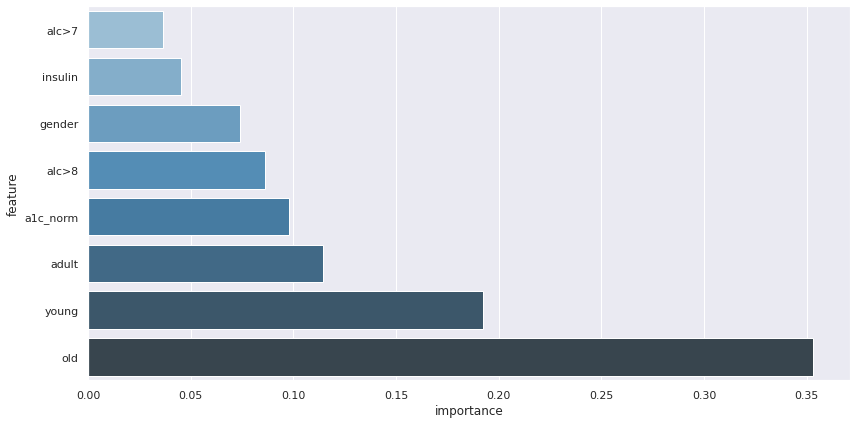

In [90]:
lst = []

for idx, v in enumerate(rf_model2.feature_importances_):
    lst.append({'feature': model_features[idx], 'importance': v})
_df2 = pd.DataFrame(lst).sort_values('importance')

plt.figure(figsize=(12,6))
sns.barplot(data=_df2.tail(12), x='importance', y='feature', palette='Blues_d')
plt.tight_layout()
plt.savefig('graphs/m2_feature_importance.jpg')

## Modeling 3

A1Cresult and max_glu_serum not 0

In [23]:
df3 = df[df['A1Cresult'].ne(0) & df['max_glu_serum'].ne(0)]
a1c_dummies = pd.get_dummies(df3['A1Cresult']).rename(columns={1: 'a1c_norm', '>7': 'alc>7', '>8': 'alc>8'})
mgs = pd.get_dummies(df3['max_glu_serum']).rename(columns={1: 'glu_normal', '>200': 'glu>200', '>300': 'glu>300'})

In [24]:
df3 = pd.concat([df3.drop(['A1Cresult', 'max_glu_serum'], axis=1), a1c_dummies, mgs], axis=1)
model_features = ['a1c_norm', 'alc>7', 'alc>8', 'glu_normal', 'glu>200', 'glu>300', 'young', 'adult', 'old']
df3 = df3[model_features + ['readmitted']]

In [25]:
train_cols = df3.drop(['readmitted'], axis=1).columns
X_train, X_test, y_train, y_test = train_test_split(df3.drop(['readmitted'], axis=1), df3['readmitted'], test_size=0.15)
print('X_train: {} X_test: {}'.format(X_train.shape[0], X_test.shape[0]))

X_train: 175 X_test: 32


In [48]:
scores = []

for model, params in model_parameters.items():
    print(f'Training: {model}')
    clf = GridSearchCV(params['model'], params['params'], cv=5, return_train_score=False, verbose=1, n_jobs=-1)
    clf.fit(X_train, y_train)
    scores.append({
        'model': model,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
model_df = pd.DataFrame(scores)

Training: svm
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Training: logistic_regression
Fitting 5 folds for each of 96 candidates, totalling 480 fits


/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penal

  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 455, in _check_solver
    "penalty='none' is not supported for the liblinear solver"
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarnin

Training: random_forest
Fitting 5 folds for each of 576 candidates, totalling 2880 fits


/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 455, in _check_solver
    "penalty='none' is not supported for the liblinear solver"
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_sele

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 455, in _check_solver
    "penalty='none' is not supported for the liblinear solver"
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_sele

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selectio

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", l

    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 455, in _check_solver
    "penalty='none' is not supported for the liblinear solver"
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag e

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

One or more of the test scores are non-finite: [0.65882353 0.65310924 0.65882353 0.65882353 0.65882353 0.67630252
 0.65882353 0.66453782 0.65882353 0.67058824 0.67058824 0.65882353
 0.65882353 0.67058824 0.65882353 0.65882353 0.67630252 0.66453782
 0.67058824 0.65882353 0.66453782 0.65882353 0.65882353 0.67058824
 0.65882353 0.65882353 0.65882353 0.66453782 0.65882353 0.65882353
 0.65882353 0.65882353 0.65882353 0.65882353 0.65882353 0.65882353
 0.66453782 0.66453782 0.67058824 0.65310924 0.65882353 0.66453782
 0.66453782 0.65882353 0.65882353 0.65882353 0.65882353 0.65882353
 0.65882353 0.67630252 0.66453782 0.65882353 0.65882353 0.65882353
 0.65882353 0.65882353 0.65882353 0.65882353 0.67058824 0.66453782
 0.67630252 0.65882353 0.65310924 0.65882353 0.65882353 0.65882353
 0.65882353 0.66453782 0.65882353 0.67630252 0.65882353 0.65882353
 0.65882353 0.67630252 0.65882353 0.66453782 0.65882353 0.65882353
 0.65882353 0.65882353 0.65882353 0.65882353 0.65882353 0.65882353
 0.65882353 0.6

In [49]:
model_df
best_model = model_df.loc[2].to_dict()
best_model

{'model': 'random_forest',
 'best_score': 0.6763025210084035,
 'best_params': {'bootstrap': True,
  'max_depth': 2,
  'max_features': 'auto',
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 100,
  'oob_score': False}}

In [50]:
rf_model3 = RandomForestClassifier(**best_model['best_params']).fit(X_train,y_train)
#rf_model = RandomForestClassifier().fit(X_train,y_train)

In [51]:
rf_pred3 = rf_model3.predict(X_test)
y_prob3 = rf_model3.predict_proba(X_test)[:, 1]
print('\n'.join(classification_report(y_test, rf_pred3, target_names=['no', 'yes']).split('\n')[:4]).replace('\n\n', '\n'))
print('Training : {}'.format(rf_model3.score(X_train, y_train)))
print('Testing: {}'.format(rf_model3.score(X_test,y_test)))
print('Roc AUC: {}'.format(roc_auc_score(y_test, y_prob3)))

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


              precision    recall  f1-score   support
          no       0.00      0.00      0.00        11
         yes       0.65      1.00      0.78        20
Training : 0.6763005780346821
Testing: 0.6451612903225806
Roc AUC: 0.5113636363636364


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [52]:
pd.DataFrame(classification_report(y_test, rf_pred3, target_names=['no', 'yes'], output_dict=True)).iloc[:, :2].T.round(2).reset_index().rename(columns={'index': 'target'}).to_csv('m3_classification_report.csv', index=False)

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


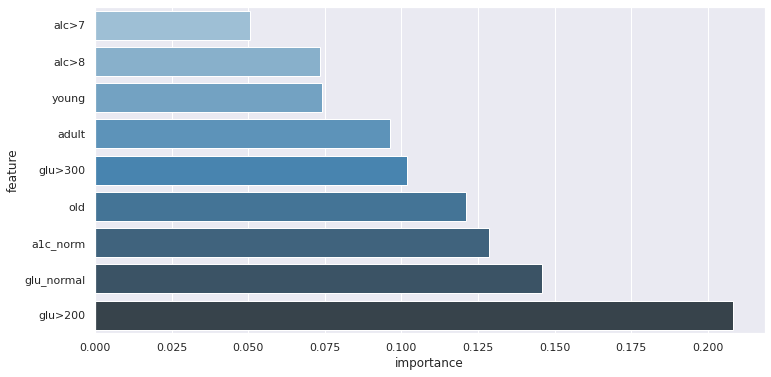

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

In [53]:
lst = []

for idx, v in enumerate(rf_model3.feature_importances_):
    lst.append({'feature': model_features[idx], 'importance': v})
df3_ = pd.DataFrame(lst).sort_values('importance')

plt.figure(figsize=(12,6))
sns.barplot(data=df3_, x='importance', y='feature', palette='Blues_d', ci=1)
plt.savefig('graphs/m3_feature_importance.jpg')

# Modeling 4

Only drug related columns

In [26]:
features = drug_cols + ['change']
model_features = features
df4 = df[model_features + ['readmitted']]

In [29]:
train_cols = df4.drop(['readmitted'], axis=1).columns
X_train, X_test, y_train, y_test = train_test_split(df4.drop(['readmitted'], axis=1), df4['readmitted'], test_size=0.15)
print('X_train: {} X_test: {}'.format(X_train.shape, X_test.shape))

X_train: (48931, 21) X_test: (8636, 21)


In [41]:
scores = []

for model, params in model_parameters.items():
    print(f'Training: {model}')
    clf = GridSearchCV(params['model'], params['params'], cv=5, return_train_score=False, verbose=1, n_jobs=-1)
    clf.fit(X_train, y_train)
    scores.append({
        'model': model,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
model_df = pd.DataFrame(scores)

Training: svm
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Training: logistic_regression
Fitting 5 folds for each of 96 candidates, totalling 480 fits


/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_sele

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_v

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selectio

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_v

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selectio

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 455, in _check_solver
    "penalty='none' is not supported for the liblinear solver"
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_sele

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_sele

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 451, in _check_solver
    " got solver={}.".format(solver))
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_sele

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logi

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_sele

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_v

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selectio

One or more of the test scores are non-finite: [       nan        nan 0.52144846 0.52167327 0.52167327 0.52167327
        nan        nan        nan 0.5216324  0.52165283        nan
        nan        nan 0.52144846 0.52167327 0.52167327 0.52167327
        nan        nan        nan 0.52167327 0.52165283        nan
        nan        nan 0.52167327 0.52167327 0.52165283 0.52165283
        nan        nan        nan 0.5216324  0.52165283        nan
        nan        nan 0.52167327 0.52165283 0.52165283 0.52165283
        nan        nan        nan 0.52167327 0.52165283        nan
        nan        nan 0.52165283 0.52167327 0.52165283 0.52165283
        nan        nan        nan 0.5216324  0.52165283        nan
        nan        nan 0.52165283 0.52165283 0.52165283 0.52165283
        nan        nan        nan 0.52167327 0.52165283        nan
        nan        nan 0.52165283 0.52163239 0.52165283 0.52165283
        nan        nan        nan 0.5216324  0.52165283        nan
        nan    

Training: random_forest
Fitting 5 folds for each of 576 candidates, totalling 2880 fits


/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 451, in _check_solver
    " got solver={}.".format(solver))
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_v

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_sele

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_v

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore th

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_v

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore th

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 455, in _check_solver
    "penalty='none' is not supported for the liblinear solver"
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_sele

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_sele

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logi

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_sele

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_sele

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 451, in _check_solver
    " got solver={}.".format(solver))
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/sit

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

One or more of the test scores are non-finite: [0.51971134 0.52247046 0.52071276 0.52063101 0.52085582 0.52187771
 0.52242951 0.52283826 0.52012009 0.52116239 0.52167333 0.52175507
 0.52179595 0.52181639 0.52161202 0.52081495 0.52097845 0.52148939
 0.5220412  0.52175509 0.52202076 0.52310393 0.52341049 0.52132589
 0.52134635 0.52234774 0.52193902 0.5205084  0.52165289 0.52191857
 0.52236819 0.52232732 0.52167333 0.52234777 0.52263388 0.52159159
 0.52179595 0.52263387 0.52101932 0.52091714 0.52067198 0.52169374
 0.52234776 0.52193902 0.52155071 0.52159157 0.52244994 0.52173464
 0.52012009 0.52085583 0.52171419 0.52122371 0.52247039 0.52181638
 0.52081495 0.52208208 0.52220469 0.52255212 0.52112152 0.52126457
 0.52099889 0.52157113 0.52101932 0.52112153 0.52097846 0.52140765
 0.52189815 0.52101933 0.52136676 0.52193901 0.52169376 0.52236819
 0.52116239 0.52056971 0.52020183 0.51991571 0.52177551 0.52187771
 0.52218425 0.52087627 0.52128501 0.52214335 0.5212237  0.52179595
 0.52110107 0.5

In [42]:
print(model_df)
best_model = model_df.loc[2].to_dict()
best_model

                 model  best_score  \
0                  svm    0.526333   
1  logistic_regression    0.521673   
2        random_forest    0.524432   

                                         best_params  
0                         {'C': 20, 'kernel': 'rbf'}  
1  {'C': 10, 'max_iter': 100, 'penalty': 'l2', 's...  
2  {'bootstrap': True, 'max_depth': 4, 'max_featu...  


{'model': 'random_forest',
 'best_score': 0.5244323568819451,
 'best_params': {'bootstrap': True,
  'max_depth': 4,
  'max_features': 'auto',
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 125,
  'oob_score': False}}

In [43]:
rf_model4 = RandomForestClassifier(**best_model['best_params']).fit(X_train,y_train)
rf_pred4 = rf_model4.predict(X_test)
y_prob4 = rf_model4.predict_proba(X_test)[:, 1]
print('\n'.join(classification_report(y_test, rf_pred4, target_names=['no', 'yes']).split('\n')[:4]).replace('\n\n', '\n'))
print('Training : {}'.format(rf_model4.score(X_train, y_train)))
print('Testing: {}'.format(rf_model4.score(X_test,y_test)))
print('Roc AUC: {}'.format(roc_auc_score(y_test, y_prob4)))

              precision    recall  f1-score   support
          no       0.53      0.59      0.56      4335
         yes       0.53      0.47      0.50      4300
Training : 0.5253724632645971
Testing: 0.5317892298784018
Roc AUC: 0.544892867680588


In [44]:
pd.DataFrame(classification_report(y_test, rf_pred4, target_names=['no', 'yes'], output_dict=True)).iloc[:, :2].T.round(2).reset_index().rename(columns={'index': 'target'}).to_csv('m4_classification_report.csv', index=False)

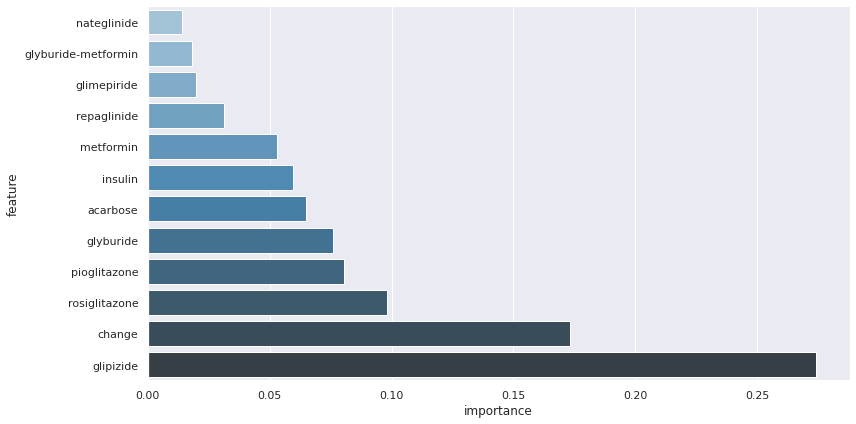

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 352, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ke

In [111]:
lst = []

for idx, v in enumerate(rf_model4.feature_importances_):
    lst.append({'feature': model_features[idx], 'importance': v})
df4_ = pd.DataFrame(lst).sort_values('importance')

plt.figure(figsize=(12,6))
sns.barplot(data=df4_.tail(12), x='importance', y='feature', palette='Blues_d')
plt.tight_layout()
plt.savefig('graphs/m4_feature_importance.jpg')

In [ ]:
explainer = shap.TreeExplainer(rf_model)
choosen_instance = X_test.iloc[[42]]
shap_values = explainer.shap_values(choosen_instance)
#shap.summary_plot(shap_values, X_test)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

## Modeling 5

replace missing with -1 for a1c and glu

In [ ]:
features = ['gender', 'old', 'young', 'adult', 'time_in_hospital', 'num_lab_procedures', 
            'num_procedures', 'num_medications', 'number_diagnoses', 'diabetesMed']
glucose_tests = ['max_glu_serum', 'A1Cresult']
num_cols = ['time_in_hospital','num_lab_procedures', 'num_medications','number_diagnoses']
model_features = features+glucose_tests+num_cols

In [ ]:
df['A1Cresult'].value_counts()

In [ ]:
a1c_dummies = pd.get_dummies(df['A1Cresult']).rename(columns={0: -1, 1: 'a1c_norm', '>7': 'alc>7', '>8': 'alc>8'})
mgs = pd.get_dummies(df['max_glu_serum']).rename(columns={0: -1, 1: 'glu_normal', '>200': 'glu>200', '>300': 'glu>300'})

df4 = pd.concat([a1c_dummies, mgs])

In [ ]:
df4

# Conclusions 

In the United States, 88 million adults, more than 1 in 3 have prediabetes. What’s more, more than 84% of them don’t know they have it. The analysis done in this report is just a tiny fraction of the enormous work put into this field. The models trained here can do better with more data points and more features. However with the limited data the models created performed well.